In [86]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import mlrose as rose
from mlrose_hiive import NeuralNetwork, simulated_annealing, random_hill_climb, NNClassifier, genetic_alg
from sklearn.metrics import accuracy_score
import itertools
import math
    
def load_occupancy_training():
    enc = OrdinalEncoder()
    
    f = open('./datatraining.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def load_occupancy_test():
    enc = OrdinalEncoder()
    
    f = open('./datatest.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def get_best_model(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i

    best_model = scores['estimator'][best_index]
    return best_model

def get_best_score(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i
        
    return best, best_index

# Load and separate Occupancy Training, Validation, and Test Sets

occupancyTrainX, occupancyTrainY = load_occupancy_training()
occTestX, occTestY = load_occupancy_test()

occTrainX, occValidX, occTrainY, occValidY = train_test_split(occupancyTrainX, occupancyTrainY, test_size=.2)

# Load ad separate Digit Training, Validation, and Test Sets

digitData, digitTarget = load_digits(return_X_y=True)
trainDigitX, testDigitX, trainDigitY, testDigitY = train_test_split(digitData, digitTarget, test_size=.2)

trainDigitX, validDigitX, trainDigitY, validDigitY = train_test_split(trainDigitX, trainDigitY, test_size=.2, shuffle=True)




In [7]:
# Learning Curve plotting function

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    


In [116]:
def max_half_and_end(state):
    # Maximize number of ones in first half of state, and have a 1 at the very end
    mid = len(state)//2
    left = state[:mid]
    right = state[mid:-1]
    
    
    return sum(left) + state[-1] + (len(right) - sum(right))

def max_three_zeros(state):
    #Attempts to maximize the number of 000 in the given list.
    i = 0
    zeros_count = 0
    total = 0
    while i <= len(state):
        if i == len(state):
            total = total + 1 if zeros_count == 3 else total
            break
        if state[i] == 0:
            zeros_count += 1
        elif zeros_count == 3:
            total += 1
            zeros_count = 0
        else:
            zeros_count = 0
        
        i+=1
    
    return total

def on_off(state):
    count = 0
    for i in range(len(state)):
        if i % 2 == 0:
            count += 1 if state[i] == 1 else 0
        else:
            count += 1 if state[i] == 0 else 0
    return count

def palindrome(state):
    s = sum(state)
    if s == 0 or s == len(state):
        return 0
    last = len(state) - 1
    i = 0
    count = 0
    while i < last:
        if state[i] == state[last]:
            count += 1
            i += 1
            last -= 1
        else:
            break
    
    return count * 2 

def max_primes(state):
    primes = set([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 
              89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 
              181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251])
    
    my_int = lambda ls : int('0b' + ''.join([str(i) for i in ls]), 2)
    score = 0
    for i in range(0, len(state), 8):
        digit = my_int(state[i:i+8])
        score += digit if digit in primes else 0
    
    return score
        
# Initialize Constants

halfFitness = mlrose.CustomFitness(max_half_and_end)
zeroFitness = mlrose.CustomFitness(max_three_zeros)
onesFitness = mlrose.OneMax()
onoffFitness = mlrose.CustomFitness(on_off)
palFitness = mlrose.CustomFitness(palindrome)
primeFitness = mlrose.CustomFitness(max_primes)
LENGTH = 200
attempts = [10, 25, 50, 100, 200]
iters = [10, 50, 100, 250, 500, math.inf]
restarts = [0, 10, 50, 100, 250]
init_state = np.array([0 for i in range(LENGTH)])
schedules = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
pop_sizes = [2, 10, 50, 100, 200, 500]
mutation_probs = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Initialize Problems

onesProblem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = onesFitness, maximize = True, max_val = 2)
zerosProblem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = zeroFitness, maximize=True, max_val = 2)
halfProblem = mlrose.DiscreteOpt(length=LENGTH, fitness_fn = halfFitness, maximize=True, max_val = 2)
onoffProblem = mlrose.DiscreteOpt(length=LENGTH, fitness_fn = onoffFitness, maximize=True, max_val=2)
palProblem = mlrose.DiscreteOpt(length=LENGTH, fitness_fn = palFitness, maximize=True, max_val=2)
primeProblem = mlrose.DiscreteOpt(length=LENGTH, fitness_fn = primeFitness, maximize=True, max_val=2)

rhcCombos = [i for i in itertools.product(attempts, iters, restarts)]
saCombos = [i for i in itertools.product(schedules, attempts, iters)]
gaCombos = [i for i in itertools.product(attempts, iters)]



In [9]:
def get_param_grid(algoObj, combo, param_grid):
    new_grid = param_grid.copy()
    if algoObj == mlrose.random_hill_climb:
        new_grid['max_attempts'] = combo[0]
        new_grid['max_iters'] = combo[1]
        new_grid['restarts'] = combo[2]
    elif algoObj == mlrose.simulated_annealing:
        new_grid['schedule'] = combo[0]
        new_grid['max_attempts'] = combo[1]
        new_grid['max_iters'] = combo[2]
    elif (algoObj == mlrose.genetic_alg or algoObj == mlrose.mimic):
        new_grid['max_attempts'] = combo[0]
        new_grid['max_iters'] = combo[1]

    return new_grid
        

def run_optimization_problem(combos, algorithm, params):
    current_state = current_fitness = 0
    best_state = best_fitness = 0
    best_combo = None
    best_mean = 0

    for combo in combos:
        d = get_param_grid(algorithm, combo, params)

        current_state, current_fitness, curves = algorithm(**d)
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_state = current_state
            best_combo = combo
    
    return best_state, best_fitness, curves, best_combo

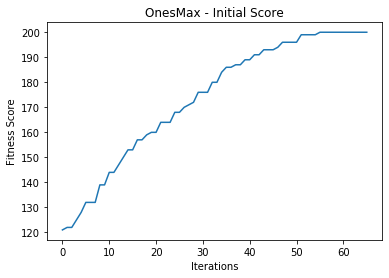

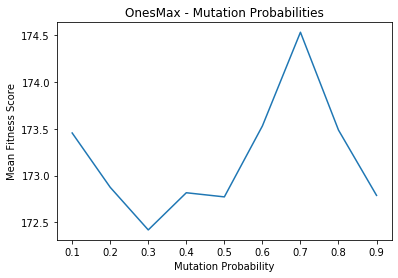

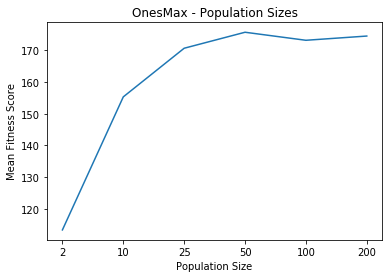

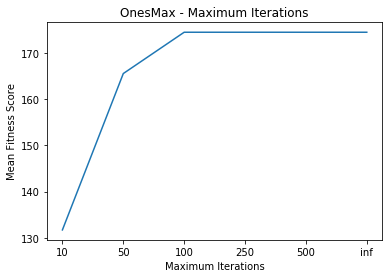

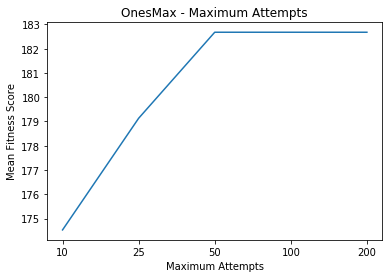

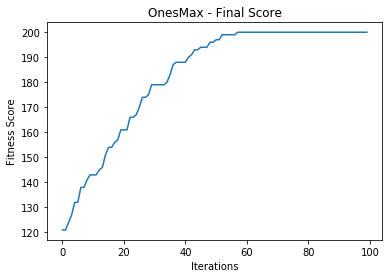

200.0


In [166]:
# Genetic Algorithm - OnesMax

ga = mlrose.genetic_alg
title = "OnesMax"

param_grid = {
    'problem': onesProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = ga(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# Run Algorithm Over different mutation probabilities
means = []
for prob in [i/10 for i in range(1, 10)]:
    param_grid['mutation_prob'] = prob
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([i/10 for i in range(1, 10)], means)
plt.title("{} - Mutation Probabilities".format(title))
plt.xlabel("Mutation Probability")
plt.ylabel("Mean Fitness Score")
plt.show()

# Adjust mutation probability and run over different population sizes
param_grid['mutation_prob'] = .7
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 100
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 100
best_state, best_fitness, curves = ga(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)


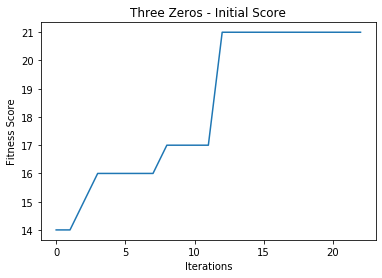

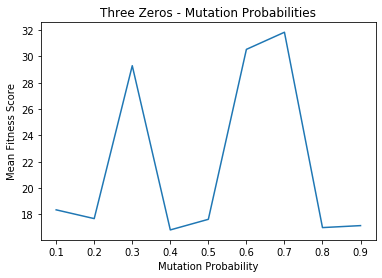

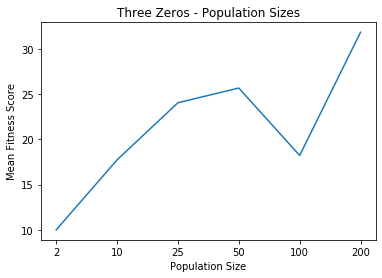

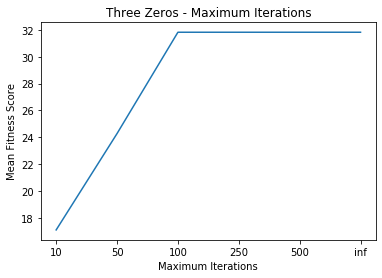

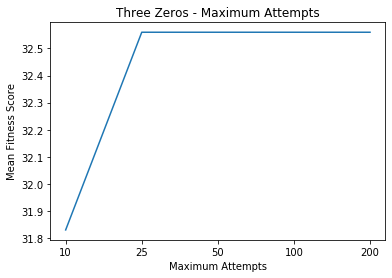

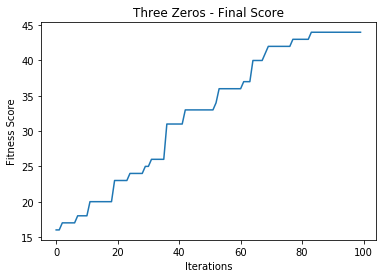

44.0


In [148]:
# Genetic Algorithm - Three Zeros Problem

ga = mlrose.genetic_alg
title = "Three Zeros"

param_grid = {
    'problem': zerosProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = ga(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# Run Algorithm Over different mutation probabilities
means = []
for prob in [i/10 for i in range(1, 10)]:
    param_grid['mutation_prob'] = prob
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([i/10 for i in range(1, 10)], means)
plt.title("{} - Mutation Probabilities".format(title))
plt.xlabel("Mutation Probability")
plt.ylabel("Mean Fitness Score")
plt.show()

# Adjust mutation probability and run over different population sizes
param_grid['mutation_prob'] = .7
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 100
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 100
best_state, best_fitness, curves = ga(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)


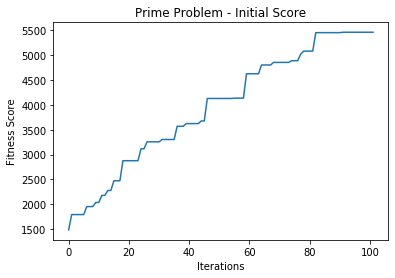

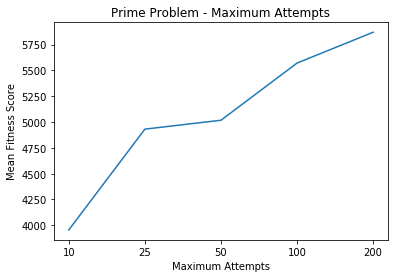

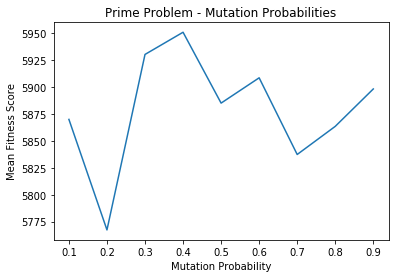

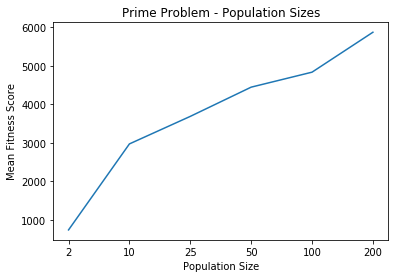

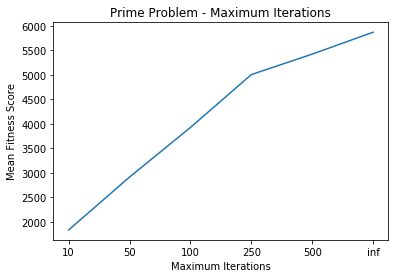

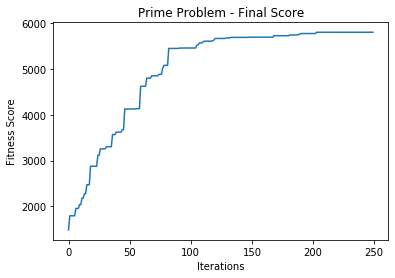

5807.0


In [176]:
# Genetic Algorithm - Prime Problem

ga = mlrose.genetic_alg
title = "Prime Problem"

param_grid = {
    'problem': primeProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = ga(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Run Algorithm Over different mutation probabilities
means = []
for prob in [i/10 for i in range(1, 10)]:
    param_grid['mutation_prob'] = prob
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([i/10 for i in range(1, 10)], means)
plt.title("{} - Mutation Probabilities".format(title))
plt.xlabel("Mutation Probability")
plt.ylabel("Mean Fitness Score")
plt.show()

# Adjust mutation probability and run over different population sizes
param_grid['mutation_prob'] = .1
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = ga(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
# means = []
# for i in attempts:
#     param_grid['max_attempts'] = i
#     best_state, best_fitness, curves = ga(**param_grid)
#     means.append(np.mean(curves))

# plt.plot([str(i) for i in attempts], means)
# plt.xlabel("Maximum Attempts")
# plt.ylabel("Mean Fitness Score")
# plt.title("{} - Maximum Attempts".format(title))
# plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 50
best_state, best_fitness, curves = ga(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)

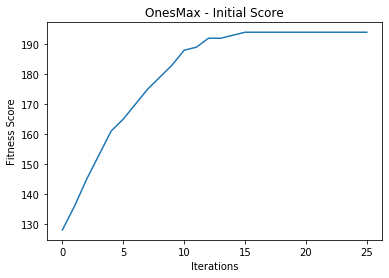

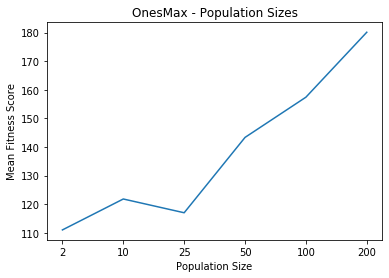

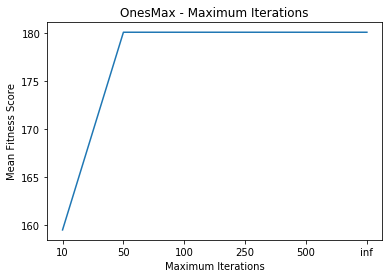

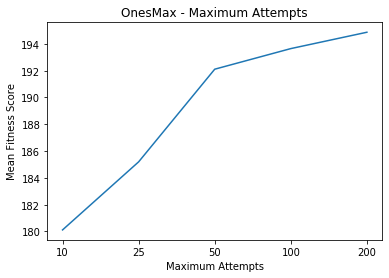

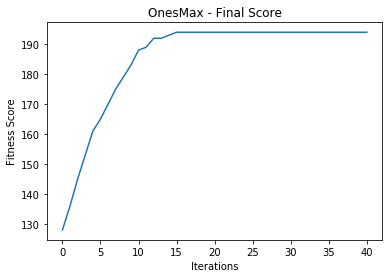

In [89]:
# MIMIC algorithm - OnesMax

mimic = mlrose.mimic
title = "OnesMax"

param_grid = {
    'problem': onesProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = mimic(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# Adjust mutation probability and run over different population sizes
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 25
best_state, best_fitness, curves = mimic(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()


In [153]:
# MIMIC algorithm - Three Zeros

mimic = mlrose.mimic
title = "Three Zeros"

param_grid = {
    'problem': zerosProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = mimic(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# # Run Algorithm Over different mutation probabilities
# means = []
# for prob in [i/10 for i in range(1, 10)]:
#     param_grid['mutation_prob'] = prob
#     best_state, best_fitness, curves = mimic(**param_grid)
#     means.append(np.mean(curves))

# plt.plot([i/10 for i in range(1, 10)], means)
# plt.title("{} - Mutation Probabilities".format(title))
# plt.xlabel("Mutation Probability")
# plt.ylabel("Mean Fitness Score")
# plt.show()

# Adjust mutation probability and run over different population sizes
# param_grid['mutation_prob'] = .4
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 200
best_state, best_fitness, curves = mimic(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()


KeyboardInterrupt: 

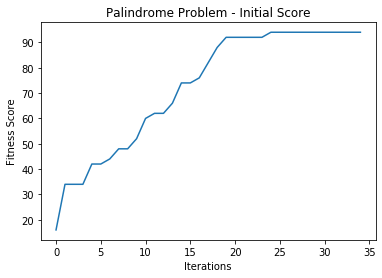

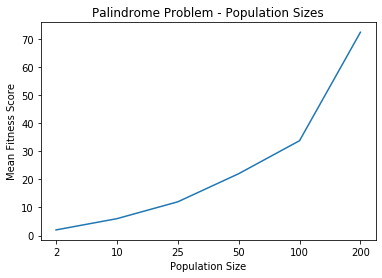

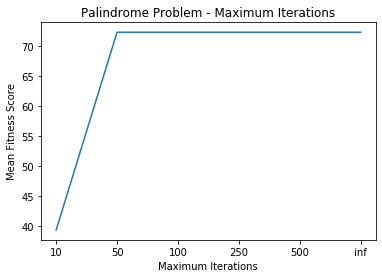

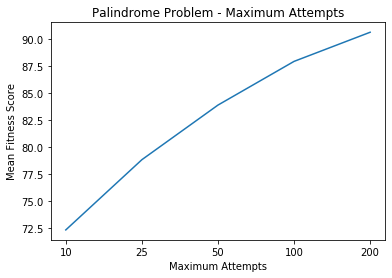

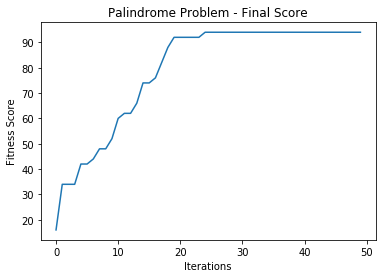

In [91]:
# MIMIC algorithm - Prime Problem

mimic = mlrose.mimic
title = "Prime Problem"

param_grid = {
    'problem': primeProblem,
    'random_state': 5,
    'curve': True
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = mimic(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# # Run Algorithm Over different mutation probabilities
# means = []
# for prob in [i/10 for i in range(1, 10)]:
#     param_grid['mutation_prob'] = prob
#     best_state, best_fitness, curves = mimic(**param_grid)
#     means.append(np.mean(curves))

# plt.plot([i/10 for i in range(1, 10)], means)
# plt.title("{} - Mutation Probabilities".format(title))
# plt.xlabel("Mutation Probability")
# plt.ylabel("Mean Fitness Score")
# plt.show()

# Adjust mutation probability and run over different population sizes
# param_grid['mutation_prob'] = .4
means = []
for pop in [2, 10, 25, 50, 100, 200]:
    param_grid['pop_size'] = pop
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot(['2', '10', '25', '50', '100', '200'], means)
plt.xlabel("Population Size")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Population Sizes".format(title))
plt.show()

# Adjust population size and run over different maximum iterations
param_grid['pop_size'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = mimic(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and compare to original
param_grid['max_attempts'] = 25
best_state, best_fitness, curves = mimic(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()


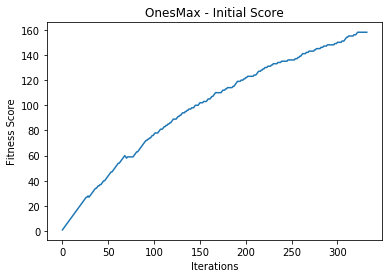

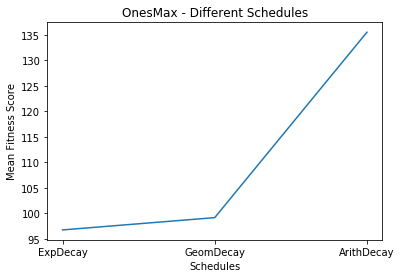

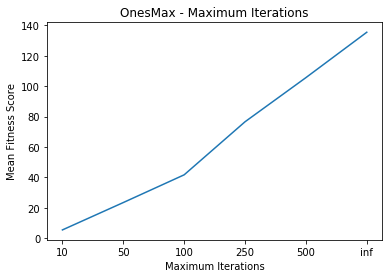

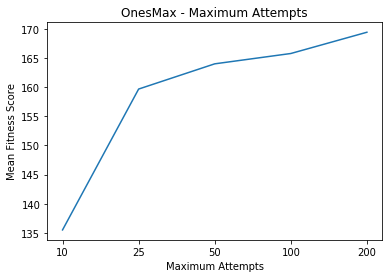

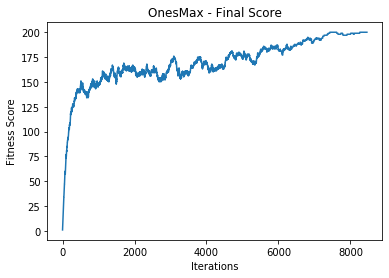

200.0


In [171]:
# Simulated Annealing - OnesMax Problem

sa = mlrose.simulated_annealing
title = "OnesMax"

param_grid = {
    'problem': onesProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = sa(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# param_grid['max_attempts'] = 50
means = []
for sched in schedules:
    param_grid['schedule'] = sched
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot(['ExpDecay', 'GeomDecay', 'ArithDecay'], means)
plt.xlabel("Schedules")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Different Schedules".format(title))
plt.show()

# run over different maximum iterations

means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = math.inf
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

param_grid['max_attempts'] = 200
    
best_state, best_fitness, curves = sa(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)


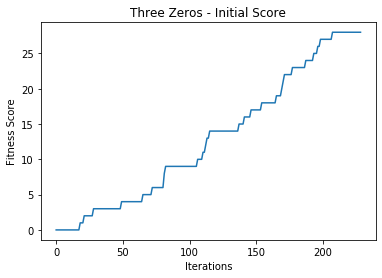

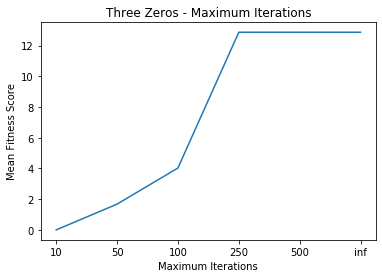

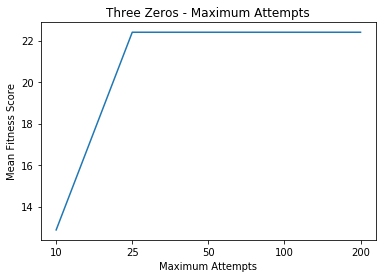

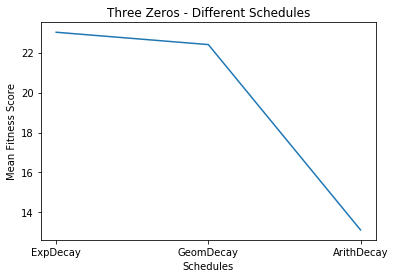

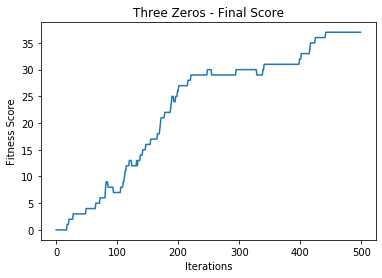

37.0


In [173]:
# Simulated Annealing - Three Zeros Problem

sa = mlrose.simulated_annealing
title = "Three Zeros"

param_grid = {
    'problem': zerosProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = sa(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()


# run over different maximum iterations

means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 500
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and test different schedules
param_grid['max_attempts'] = 200
means = []
for sched in schedules:
    param_grid['schedule'] = sched
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot(['ExpDecay', 'GeomDecay', 'ArithDecay'], means)
plt.xlabel("Schedules")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Different Schedules".format(title))
plt.show()

param_grid['schedule'] = mlrose.ExpDecay()
    
best_state, best_fitness, curves = sa(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)


In [ ]:
# Simulated Annealing - Prime Problem

sa = mlrose.simulated_annealing
title = "Prime Problem"

param_grid = {
    'problem': primeProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = sa(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()

# param_grid['max_attempts'] = 25
means = []
for sched in schedules:
    param_grid['schedule'] = sched
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot(['ExpDecay', 'GeomDecay', 'ArithDecay'], means)
plt.xlabel("Schedules")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Different Schedules".format(title))
plt.show()


# run over different maximum iterations

means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
# param_grid['max_iters'] = 500
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = sa(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Adjust attempt size and test different schedules
# param_grid['max_attempts'] = 25
# means = []
# for sched in schedules:
#     param_grid['schedule'] = sched
#     best_state, best_fitness, curves = sa(**param_grid)
#     means.append(np.mean(curves))

# plt.plot(['ExpDecay', 'GeomDecay', 'ArithDecay'], means)
# plt.xlabel("Schedules")
# plt.ylabel("Mean Fitness Score")
# plt.title("{} - Different Schedules".format(title))
# plt.show()
    
param_grid['schedule'] = mlrose.ArithDecay()
best_state, best_fitness, curves = sa(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()


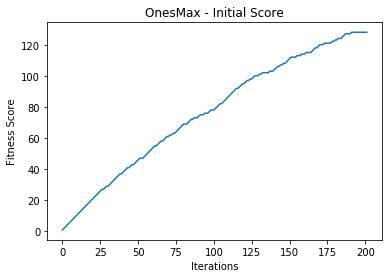

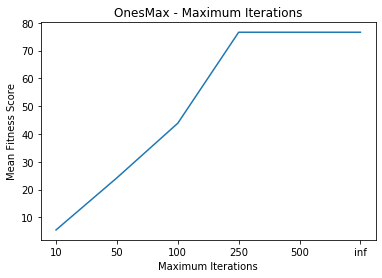

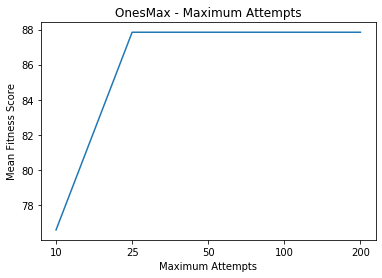

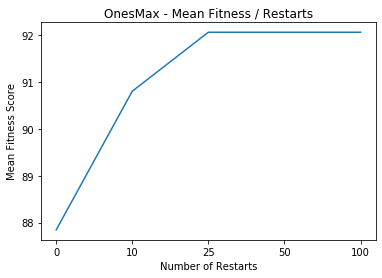

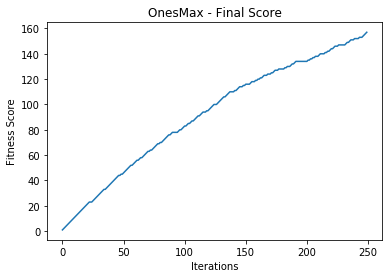

In [76]:
# Random Hill Climb - OnesMax

rhc = mlrose.random_hill_climb
title = "OnesMax"

param_grid = {
    'problem': onesProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = rhc(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()


# run over different maximum iterations

means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Run Over Various restarts
param_grid['max_attempts'] = 25
means = []
for i in [0, 10, 25, 50, 100]:
    param_grid['restarts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in [0, 10, 25, 50, 100]], means)
plt.xlabel("Number of Restarts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Mean Fitness / Restarts".format(title))
plt.show()

param_grid['restarts'] = 25
    
best_state, best_fitness, curves = rhc(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()


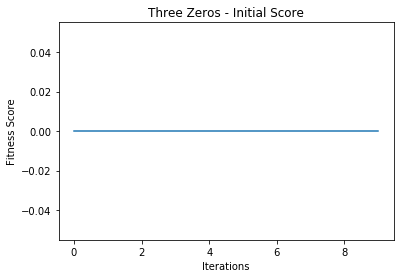

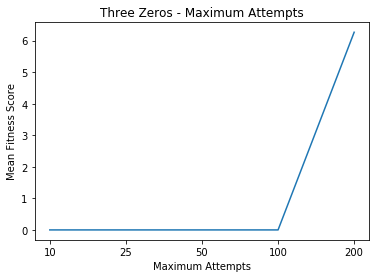

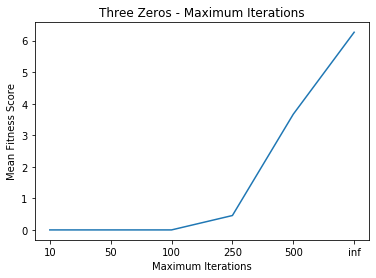

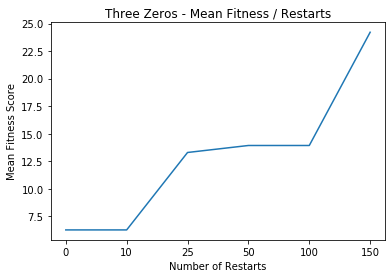

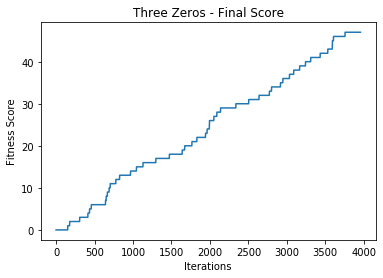

47.0


In [163]:
# Random Hill Climb - Three Zeros Problem

rhc = mlrose.random_hill_climb
title = "Three Zeros"

param_grid = {
    'problem': zerosProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = rhc(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()


# param_grid['max_iters'] = 500
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# run over different maximum iterations
param_grid['max_attempts'] = 200
means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
# param_grid['max_iters'] = 500
# means = []
# for i in attempts:
#     param_grid['max_attempts'] = i
#     best_state, best_fitness, curves = rhc(**param_grid)
#     means.append(np.mean(curves))

# plt.plot([str(i) for i in attempts], means)
# plt.xlabel("Maximum Attempts")
# plt.ylabel("Mean Fitness Score")
# plt.title("{} - Maximum Attempts".format(title))
# plt.show()

# Run Over Various restarts
# param_grid['max_attempts'] = 200
means = []
for i in [0, 10, 25, 50, 100, 150]:
    param_grid['restarts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in [0, 10, 25, 50, 100, 150]], means)
plt.xlabel("Number of Restarts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Mean Fitness / Restarts".format(title))
plt.show()

param_grid['restarts'] = 150
    
best_state, best_fitness, curves = rhc(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()

print(best_fitness)

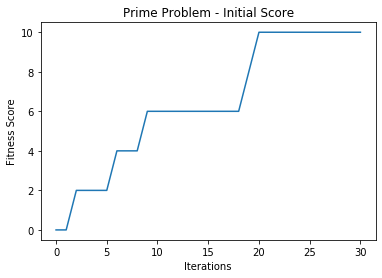

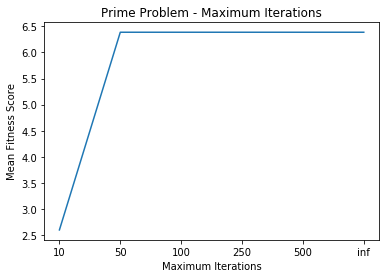

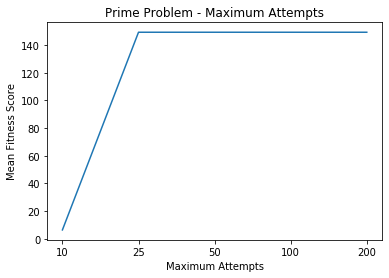

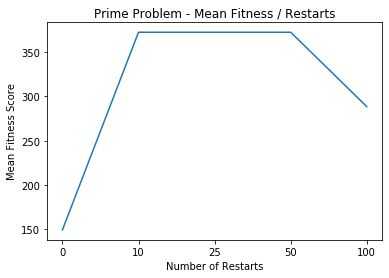

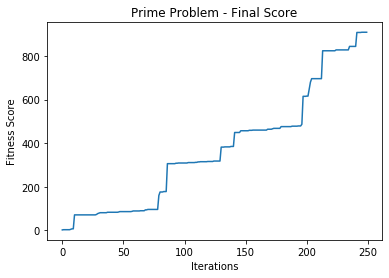

In [124]:
# Random Hill Climb - Prime Problem

rhc = mlrose.random_hill_climb
title = "Prime Problem"

param_grid = {
    'problem': primeProblem,
    'random_state': 5,
    'curve': True,
    'init_state': init_state
}

# Run Algorithm with default parameters
best_state, best_fitness, curves = rhc(**param_grid)
plt.plot(curves)
plt.title("{} - Initial Score".format(title))
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.show()


# run over different maximum iterations

means = []
for i in iters:
    param_grid['max_iters'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in iters], means)
plt.xlabel("Maximum Iterations")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Iterations".format(title))
plt.show()

# Adjust iteration size and run over attempts
param_grid['max_iters'] = 250
means = []
for i in attempts:
    param_grid['max_attempts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in attempts], means)
plt.xlabel("Maximum Attempts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Maximum Attempts".format(title))
plt.show()

# Run Over Various restarts
param_grid['max_attempts'] = 200
means = []
for i in [0, 10, 25, 50, 100]:
    param_grid['restarts'] = i
    best_state, best_fitness, curves = rhc(**param_grid)
    means.append(np.mean(curves))

plt.plot([str(i) for i in [0, 10, 25, 50, 100]], means)
plt.xlabel("Number of Restarts")
plt.ylabel("Mean Fitness Score")
plt.title("{} - Mean Fitness / Restarts".format(title))
plt.show()

param_grid['restarts'] = 50
    
best_state, best_fitness, curves = rhc(**param_grid)

plt.plot(curves)
plt.xlabel("Iterations")
plt.ylabel("Fitness Score")
plt.title("{} - Final Score".format(title))
plt.show()
